# COMPREHENSIVE DATA EXPLORATION WITH PYTHON

I tried to learn how to swim before jumping into the water.

what we are doing in this kernel is something like this:

1. **Understand the problem**. We'll look at each variable and do a philosophical analysis of their meaning and importance for this problem.
2. **Univariable study**. We'll just focus on the dependent variable ('SalePrice') and try to know a little bit more about it.
3. **Multivariate study**. We'll try to understand how the dependent variable and independent variables relate.
4. **Basic cleaning**. We'll clean the dataset and handle the missing data, outliers, and categorical variables.
5. **Test assumptions**. We'll check if our data meet the assumptions required by most multivariate techniques.

In [32]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

pd.options.display.max_columns = 100
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_train = pd.read_csv('../../data/train.csv')
df_test = pd.read_csv('../../data/test.csv')

## Overview

- There are 1460 instances of training data and 1460 of test data. Total number of attributes equals 81, of which 36 is quantitative + 43 categorical + 1 Id + SalePrice (label).

- **Quantitative**: 1stFlrSF, 2ndFlrSF, 3SsnPorch, BedroomAbvGr, BsmtFinSF1, BsmtFinSF2, BsmtFullBath, BsmtHalfBath, BsmtUnfSF, EnclosedPorch, Fireplaces, FullBath, GarageArea, GarageCars, GarageYrBlt, GrLivArea, HalfBath, KitchenAbvGr, LotArea, LotFrontage, LowQualFinSF, MSSubClass, MasVnrArea, MiscVal, MoSold, OpenPorchSF, OverallCond, OverallQual, PoolArea, ScreenPorch, TotRmsAbvGrd, TotalBsmtSF, WoodDeckSF, YearBuilt, YearRemodAdd, YrSold

- **Qualitative**: Alley, BldgType, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, BsmtQual, CentralAir, Condition1, Condition2, Electrical, ExterCond, ExterQual, Exterior1st, Exterior2nd, Fence, FireplaceQu, Foundation, Functional, GarageCond, GarageFinish, GarageQual, GarageType, Heating, HeatingQC, HouseStyle, KitchenQual, LandContour, LandSlope, LotConfig, LotShape, MSZoning, MasVnrType, MiscFeature, Neighborhood, PavedDrive, PoolQC, RoofMatl, RoofStyle, SaleCondition, SaleType, Street, Utilities,

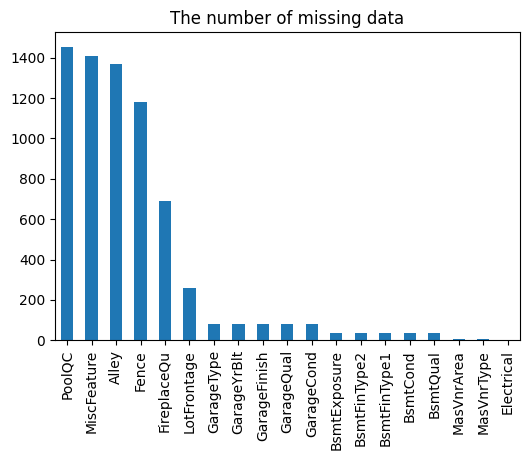

In [3]:
# Check missing data 
missing = df_train.isnull().sum()
missing = missing[missing > 0]
missing = missing.sort_values(ascending=False)

ax = missing.plot.bar(
    figsize = (6, 4)
)
ax.set_title("The number of missing data")

plt.show()

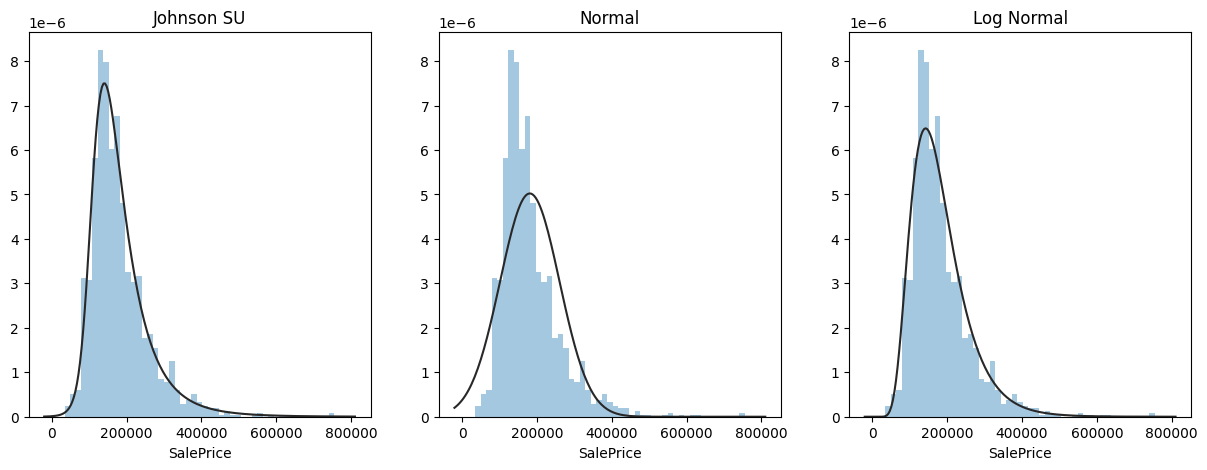

In [35]:
import scipy.stats as st
y = df_train['SalePrice']

plt.figure(figsize = (15, 5))

plt.subplot(1, 3, 1)
plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)

plt.subplot(1, 3, 2)
plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)

plt.subplot(1, 3, 3) 
plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

plt.show()

In [44]:
# The quantitative variables
quantitative = [f for f in df_train.columns if df_train.dtypes[f] != "object"]
quantitative.remove('SalePrice')
quantitative.remove('Id')

# The quanlitative variables
quanlitative = [f for f in df_train.columns if df_train.dtypes[f] == "object"]

In [57]:
# The test for normality 
test_normality = lambda x: st.shapiro(x.fillna(0))[1] < 0.01  # p_value is less than 0.01
normal = pd.DataFrame(df_train[quantitative])
normal = normal.apply(test_normality)
not normal.any()

False

### Quantitative data

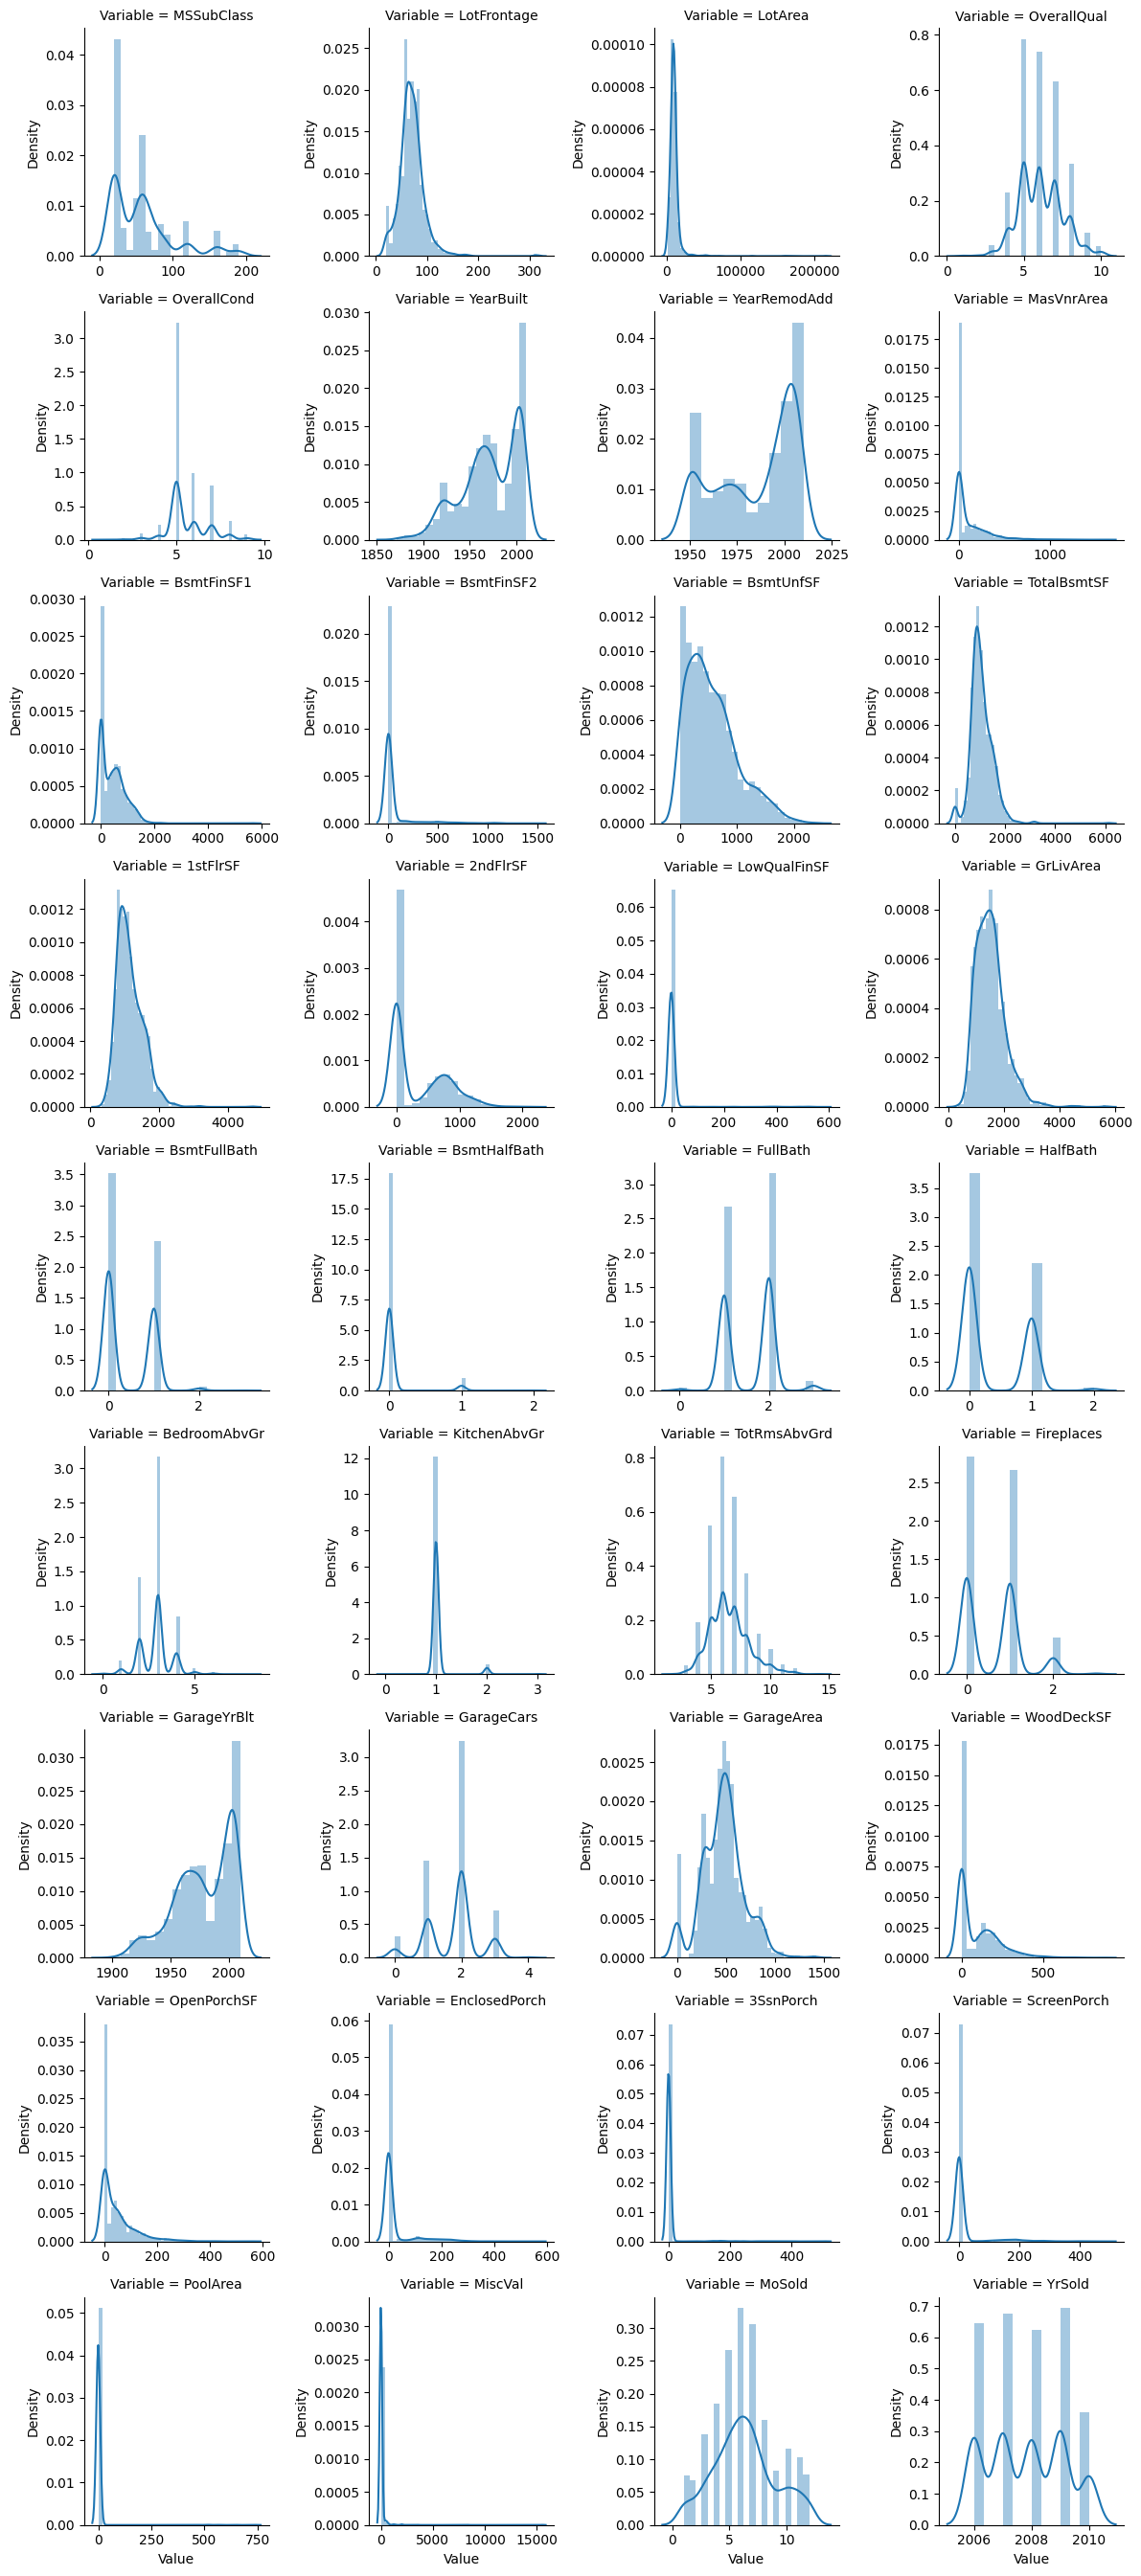

In [62]:
melted_train = pd.melt(df_train, value_vars=quantitative, value_name='Value', var_name='Variable')

# Create a FacetGrid with seaborn for plotting multiple distributions
grid = sns.FacetGrid(melted_train, col="Variable", col_wrap=4, sharex=False, sharey=False)

# Map seaborn's displot to the FacetGrid to plot the distributions
grid = grid.map(sns.distplot, "Value")

plt.show()

### Quanlitative/ Categorical data

In [78]:
# Convert quanlitative variables to categorical and handle missing values
for c in quanlitative:
    df_train[c] = df_train[c].astype('category')
    if df_train[c].isnull().any():
        df_train[c] = df_train[c].cat.add_categories(["MISSING"])
        df_train[c] = df_train[c].fillna('MISSING')

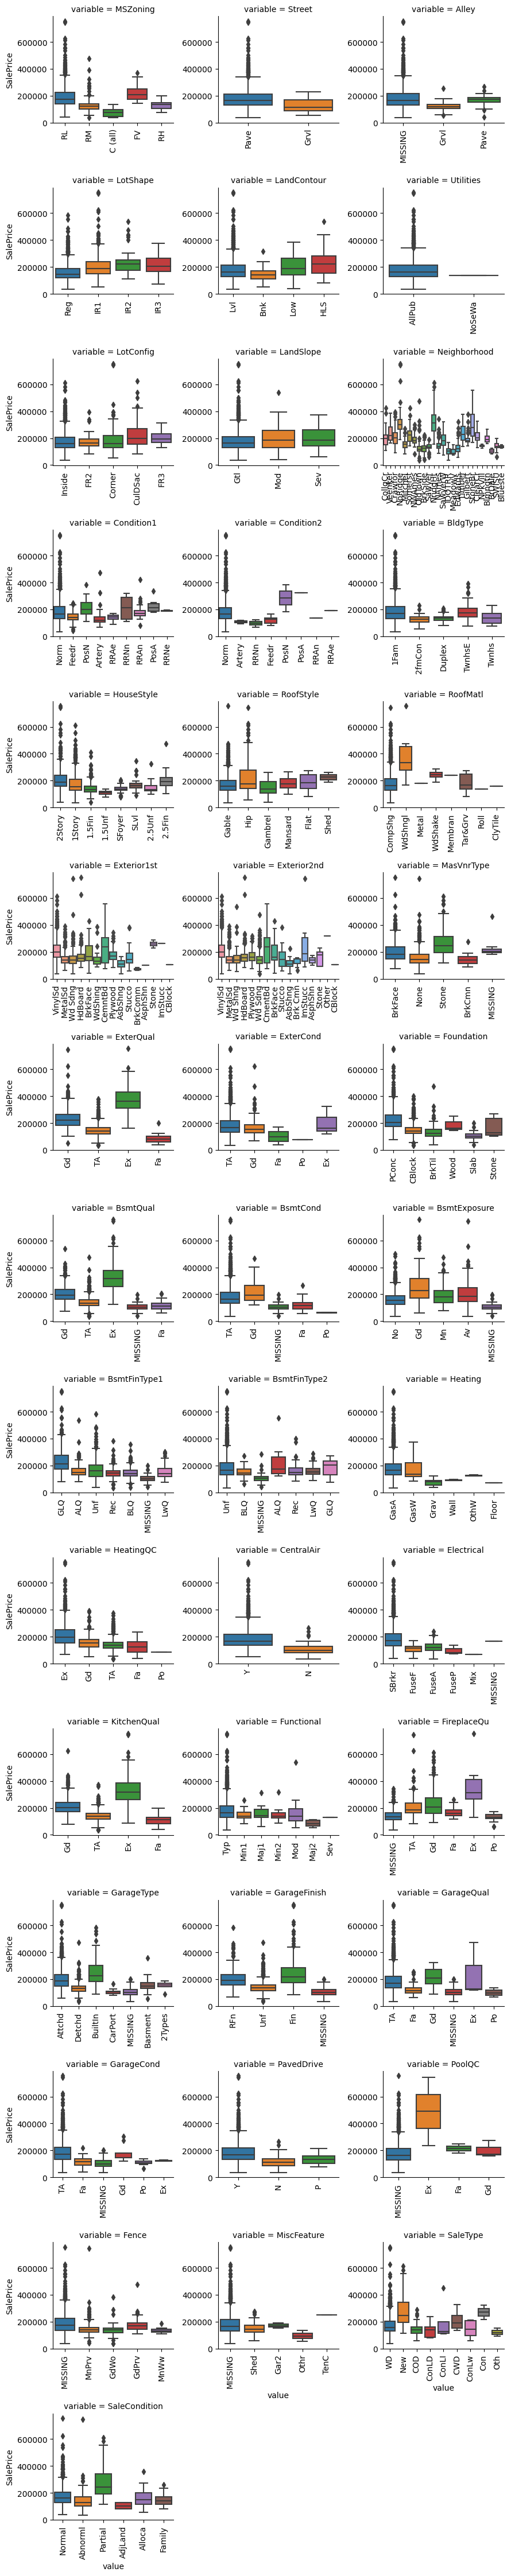

In [85]:
def custom_boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    plt.xticks(rotation=90)

# Melt the Dataframe
melted_train = pd.melt(df_train, id_vars=["SalePrice"], value_vars=quanlitative)
grid = sns.FacetGrid(melted_train, col="variable", col_wrap=3, sharex=False, sharey=False)
grid = grid.map(custom_boxplot, "value", "SalePrice")